# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

In [1]:
from fastai import *
from fastai.vision import *

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [ ]:
folder = 'black'
file = 'urls_black.txt'

In [ ]:
folder = 'teddys'
file = 'urls_teddys.txt'

In [ ]:
folder = 'grizzly'
file = 'urls_grizzly.txt'

You will need to run this line once per each category.

In [ ]:
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

![uploaded file](images/download_images/upload.png)

## Download images

Now you will need to download you images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename and the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [ ]:
classes = ['teddys','grizzly','black']

In [ ]:
download_images(path/file, dest, max_pics=200)

In [ ]:
# If you have problems download, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

teddys


grizzly


cannot identify image file '/data0/datasets/part1v3/bears/grizzly/00000011.jpg'
cannot identify image file '/data0/datasets/part1v3/bears/grizzly/00000014.jpg'
black


## View data

In [7]:
path = Path('../data/bears')

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [9]:
data.classes

['black', 'grizzly', 'teddys']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


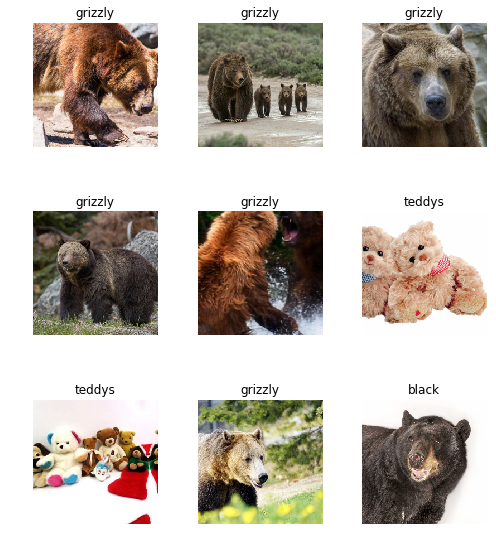

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 270, 78)

## Train model

In [12]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [13]:
learn.fit_one_cycle(4)

Total time: 00:46
epoch  train_loss  valid_loss  error_rate
1      1.033230    0.292439    0.089744    (00:12)
2      0.595514    0.118258    0.051282    (00:11)
3      0.419018    0.094726    0.025641    (00:11)
4      0.322171    0.096284    0.025641    (00:10)



In [14]:
learn.save('stage-1')

In [15]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


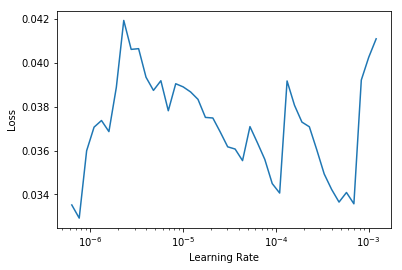

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

Total time: 00:23
epoch  train_loss  valid_loss  error_rate
1      0.063376    0.097003    0.025641    (00:11)
2      0.047585    0.087817    0.025641    (00:11)



In [20]:
learn.save('stage-2')

## Interpretation

In [21]:
learn.load('stage-2')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

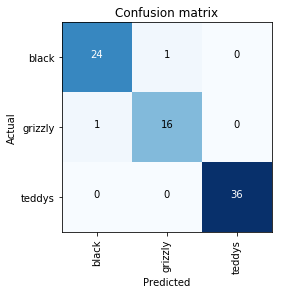

In [23]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `FileDeleter` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. Here's a handy function that pulls out all our top_losses:

In [24]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

Now we can pass in these paths to our widget.

In [25]:
fd = FileDeleter(file_paths=top_loss_paths)

'No images to show :)'

Flag photos for deletion by clicking 'Delete'. Then click 'Confirm' to delete flagged photos and keep the rest in that row. The `File_Deleter` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses`.

## Putting your model in production

In [26]:
data.classes

['black', 'grizzly', 'teddys']

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
# fastai.defaults.device = torch.device('cpu')

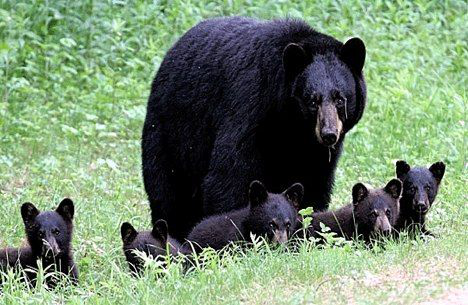

In [27]:
img = open_image(path/'black'/'00000021.jpg')
img

In [28]:
classes = ['black', 'grizzly', 'teddys']
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load('stage-2')

In [29]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'black'

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [30]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [31]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate


FileNotFoundError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py", line 204, in __getitem__
    x,y = self.ds[idx]
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/basic_data.py", line 20, in __getitem__
    if self.item is None: return self._get_x(i),self._get_y(i)
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py", line 66, in _get_x
    def _get_x(self,i): return open_image(self.x[i])
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/vision/image.py", line 366, in open_image
    x = PIL.Image.open(fn).convert('RGB')
  File "/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2609, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/coursework/data/bears/teddys/00000129.jpg'


### Learning rate (LR) too low

In [32]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [33]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate


FileNotFoundError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py", line 204, in __getitem__
    x,y = self.ds[idx]
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/basic_data.py", line 20, in __getitem__
    if self.item is None: return self._get_x(i),self._get_y(i)
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py", line 66, in _get_x
    def _get_x(self,i): return open_image(self.x[i])
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/vision/image.py", line 366, in open_image
    x = PIL.Image.open(fn).convert('RGB')
  File "/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2609, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/coursework/data/bears/teddys/00000129.jpg'


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fea22ac65c0>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


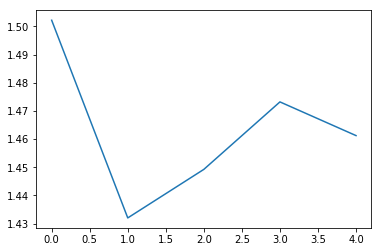

In [34]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2